# 06. Data Analytics - Local Spatial Autocorrelation

References:

Gregori, E., & Reyes Valenzuela, P. (2021). Urbana [Python / Jupyter Notebook; GitHub Repository]. Barcelona Supercomputing Center. https://github.com/egregorimar/urbana 

Rey, S. J., Arribas-Bel, D., & Wolf, L. J. (2020). Local Spatial Autocorrelation. In Geographic Data Science with Python. https://geographicdata.science/book/notebooks/07_local_autocorrelation.html 

In [1]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pysal.lib import weights
import seaborn 
from pysal.explore import esda
from splot import esda as esdaplot

/root/venv/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/root/venv/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/root/venv/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 

In [2]:
# papermill parameters cell

OUTPUT_WARNINGS = False
SAVE_FIGS = False
DROP_VARIABLE = True

VARIABLE_TO_PREDICT =  "CCI"
VARIABLE_TO_DROP = []
AREA_TO_PREDICT = "Spain" # "Spain" # "Iberian Pensinula"

In [3]:
if OUTPUT_WARNINGS is False:
    import warnings

    warnings.filterwarnings("ignore")

In [4]:
AREA_TO_PREDICT_dict = {
    "Andalusia": "01", 
    "Aragon": "02",
    "Asturias": "03", 
    "Balearic Islands": "04",
    "Canarias": "05", 
    "Cantabria": "06",
    "Castile and Leon": "07", 
    "Castille-La Mancha": "08",
    "Catalonia": "09", 
    "Valencia": "10",
    "Extremadura": "11", 
    "Galicia": "12",
    "Madrid": "13", 
    "Murcia": "14",
    "Navarre": "15", 
    "Basque Country": "16",
    "La Rioja": "17",
    "Ceuta": "18",
    "Melilla": "19",
    "Minor Plazas de Soberanía": "20",
    }

## Parameter Check

In [5]:
# Create folders to store the data
DIR_DATA = "data/"
DIR_VAR = DIR_DATA + "processed/{}/{}/".format(VARIABLE_TO_PREDICT, AREA_TO_PREDICT)
DIR_LSA = DIR_VAR + "06_lsa/"

if SAVE_FIGS:
    folder_list = [
        DIR_LSA,
        DIR_LSA + "coefficients",
    ]

    for folder in folder_list:
        if not os.path.exists(folder):
            os.makedirs(folder)

In [6]:
PATH_TO_FILE = DIR_DATA + "interim/demographic_interimdata/merged_demographic_interimdata/Spatial_demographic_interimdata.csv"
if os.path.isfile(PATH_TO_FILE) is False:
    raise Exception(
        'Please run first the notebooks with the same area and "SAVE_DATA" set to True: /n"00acquisition.ipynb", /n"01datamanagement.ipynb", /n"02dataspatialization.ipynb", /n"03index.ipynb"'
    )

## Target variable

### Dependent variable

In [7]:
# Read CCI results
CCI = pd.read_csv('data/processed/CCI/03_index/CCI_Index.csv')

# Add extra digit to dataset['CTOT'] - if it contains less than 7 characters
CCI['CTOT'] = CCI['CTOT'].apply(lambda x: '{0:0>7}'.format(x))

# Choose Study Area
if AREA_TO_PREDICT in AREA_TO_PREDICT_dict:
    CCI = CCI[CCI["CTOT"].astype(str).str.contains(r'^' + AREA_TO_PREDICT_dict[AREA_TO_PREDICT])]
elif AREA_TO_PREDICT == "Iberian Pensinula":
    #CCI = CCI[~CCI.CTOT.str.contains(r'^04')] # --> DROP BALEARIC ISLANDS
    CCI = CCI[~CCI.CTOT.str.contains(r'^05')] # --> DROP CANARIAS
    CCI = CCI[~CCI.CTOT.str.contains(r'^18')] # --> DROP CEUTA
    CCI = CCI[~CCI.CTOT.str.contains(r'^19')] # --> DROP MELILLA
    CCI = CCI[~CCI.CTOT.str.contains(r'^20')] # --> DROP MINOR PLAZAS DE SOBERINIA
elif AREA_TO_PREDICT == "Spain":
    pass

CCI.set_index("CTOT", inplace=True)

### Independent variable

In [8]:
# Read spatial dataset into GeoDataFrame
geo_info = gpd.read_file(DIR_DATA + "interim/Spatialization_interimdata/CCI_spatialization_interimdata.gpkg")

# Choose Study Area
if AREA_TO_PREDICT in AREA_TO_PREDICT_dict:
    geo_info = geo_info[geo_info["CTOT"].astype(str).str.contains(r'^' + AREA_TO_PREDICT_dict[AREA_TO_PREDICT])]
elif AREA_TO_PREDICT == "Iberian Pensinula":
    #geo_info = geo_info[~geo_info.CTOT.str.contains(r'^04')] # --> DROP BALEARIC ISLANDS
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^05')] # --> DROP CANARIAS
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^18')] # --> DROP CEUTA
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^19')] # --> DROP MELILLA
    geo_info = geo_info[~geo_info.CTOT.str.contains(r'^20')] # --> DROP MINOR PLAZAS DE SOBERINIA
elif AREA_TO_PREDICT == "Spain":
    pass

geo_info.set_index("CTOT", inplace=True)
geo_info = geo_info.drop(["Municipality"], axis=1,)

if DROP_VARIABLE is True:
    geo_info = geo_info.drop(VARIABLE_TO_DROP, axis=1,)

In [9]:
# Add dependent variable column to spatial dataset
geo_info[VARIABLE_TO_PREDICT] = CCI[VARIABLE_TO_PREDICT]

# Add dependent variable column to spatial dataset
id_max_KPI = geo_info[VARIABLE_TO_PREDICT].idxmax()

# Define area with maximum value of dependent variable
print("Area with maximum value: " + str(id_max_KPI))

Area with maximum value: 0407056


### Plot target variable

In [10]:
# Define line colors
def line_color(area):
    if area == "Spain" or area == "Iberian Pensinula": color = 'face'
    else: color = "black"
    return color

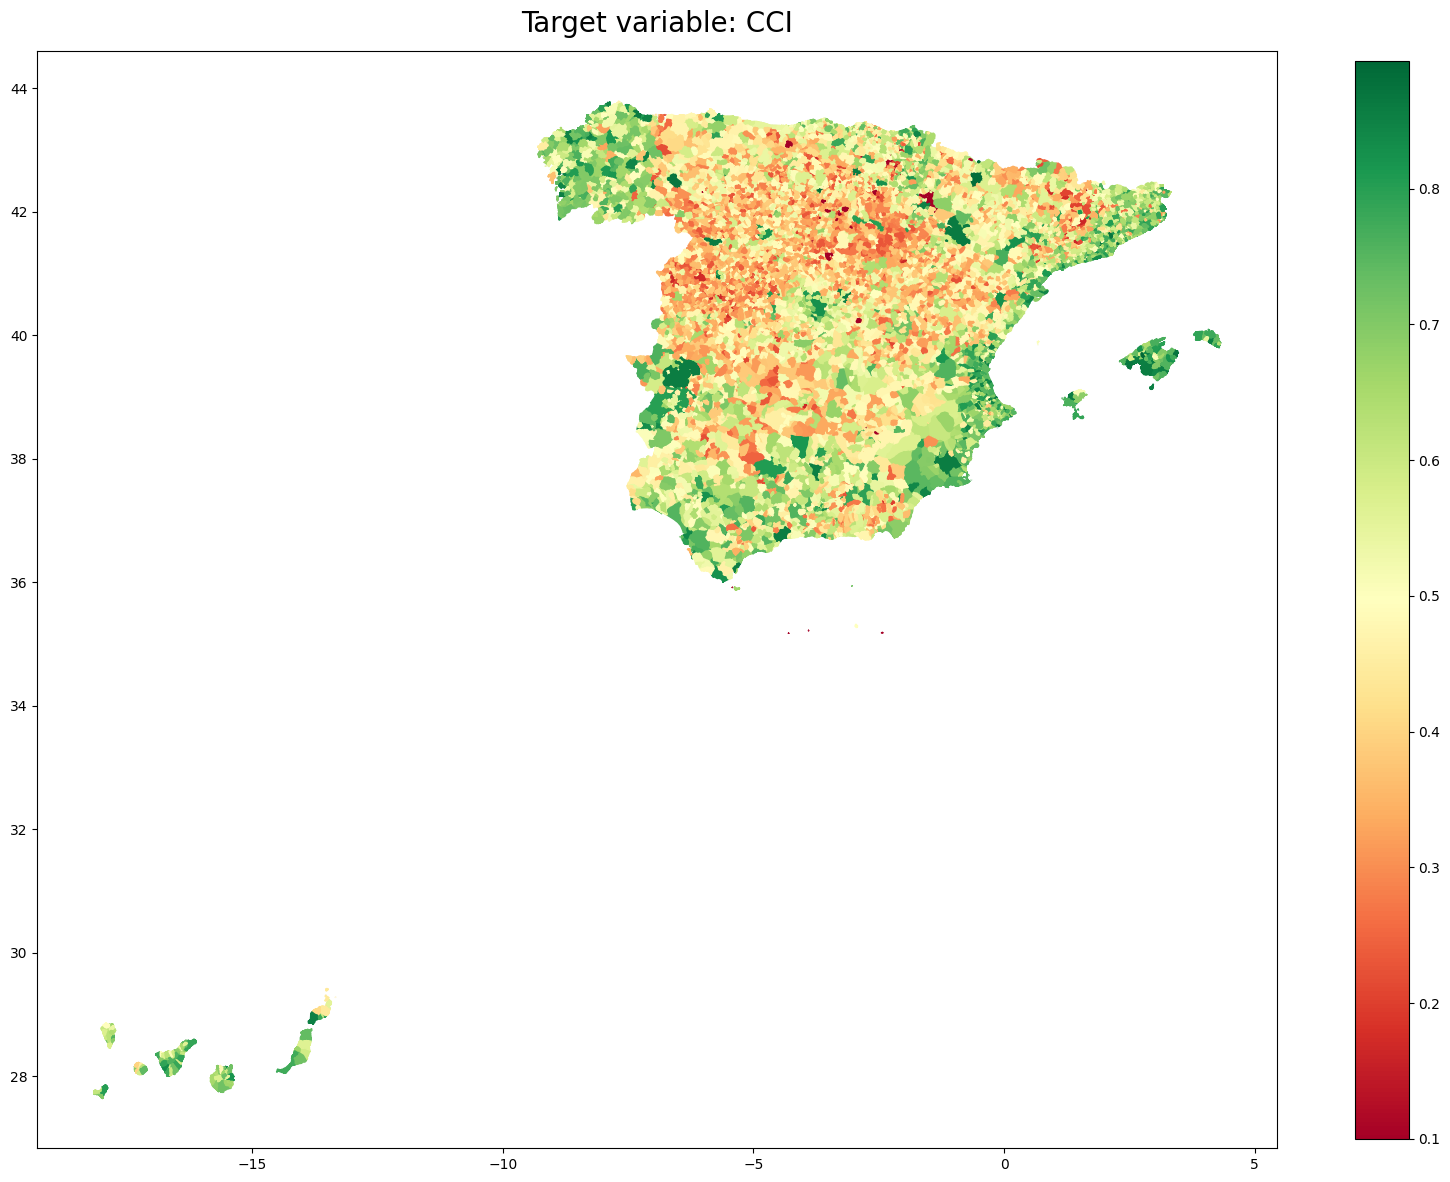

In [11]:
# Plot dependent variable (target variable)
fig, ax = plt.subplots(figsize=(20, 20))

geo_info.plot(
    ax=ax,
    column=VARIABLE_TO_PREDICT,
    edgecolor=line_color(AREA_TO_PREDICT),
    legend=True,
    figsize=(20, 20),
    cmap="RdYlGn",
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Target variable: " + str(VARIABLE_TO_PREDICT), fontsize=20, y=1.01)

if SAVE_FIGS:
    plt.savefig(DIR_LSA + "target_variable.svg", format="svg")

plt.show()

In [12]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(geo_info, k=5)

# Row-standardization
w.transform = "R"

## Local Spatial Autocorrelation

### Spatial Lag

In [13]:
# Apply geo_info spatial lag
VARIABLE_TO_PREDICT_w = VARIABLE_TO_PREDICT + '_w'
geo_info[VARIABLE_TO_PREDICT_w] = weights.spatial_lag.lag_spatial(
    w, geo_info[VARIABLE_TO_PREDICT]
)

In [14]:
VARIABLE_TO_PREDICT_std = VARIABLE_TO_PREDICT + "_std"
VARIABLE_TO_PREDICT_std_w = VARIABLE_TO_PREDICT_std + "_w"

# Calculate standard deviation vs standard deviation of weighted variable
geo_info[VARIABLE_TO_PREDICT_std] = geo_info[VARIABLE_TO_PREDICT] - geo_info[VARIABLE_TO_PREDICT].mean()
geo_info[VARIABLE_TO_PREDICT_std_w] =  geo_info[VARIABLE_TO_PREDICT_w] - geo_info[VARIABLE_TO_PREDICT].mean()

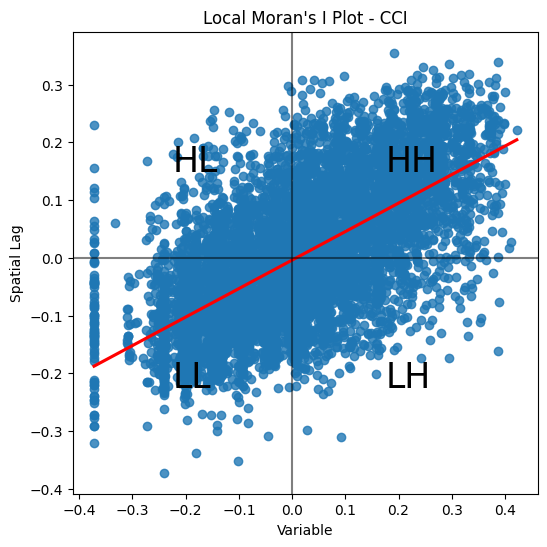

In [15]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))

# Plot values
seaborn.regplot(
    x=VARIABLE_TO_PREDICT_std, 
    y=VARIABLE_TO_PREDICT_std_w, 
    data=geo_info, 
    ci=None,    
    line_kws={"color": "r"},
)

# Add vertical and horizontal lines
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)

# Add labels and title
ax.set_xlabel("Variable")
ax.set_ylabel("Spatial Lag")
ax.set_title("Local Moran's I Plot - " + str(VARIABLE_TO_PREDICT))

# Add text labels for each quadrant
ax.text(0.175, 0.15, "HH", fontsize=25, c="k")
ax.text(-0.225, 0.15, "HL", fontsize=25, c="k")
ax.text(0.175, -0.225, "LH", fontsize=25, c="k")
ax.text(-0.225, -0.225, "LL", fontsize=25, c="k")

if SAVE_FIGS:
    plt.savefig(DIR_LSA + "local_moransI_quadrant.svg", format="svg")

# Display
plt.show()


## Local Moran's I

### Calculate LSA

In [16]:
lisa = esda.moran.Moran_Local(geo_info[VARIABLE_TO_PREDICT_w], w)

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

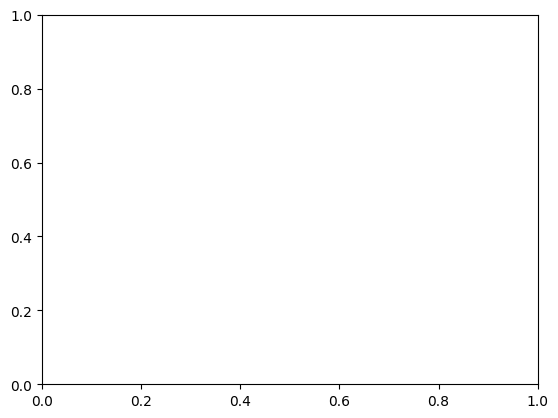

In [17]:
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax);

In [0]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

### Subplot 1 ###
# Choropleth of local statistics
ax = axs[0]
geo_info.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="face",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    legend_kwds={'loc':'lower right'},
    ax=ax,
)

### Subplot 2 ###
# Quadrant categories
ax = axs[1]
# Plot Quandrant colors
esdaplot.lisa_cluster(
    lisa, 
    geo_info, 
    p=1, 
    ax=ax,
    legend=True, 
    legend_kwds={'loc':'lower right'}
)

### Subplot 3 ###
# Significance map
ax = axs[2]

labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=geo_info.index  
    # 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})

geo_info.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="face",
    legend=True,
    legend_kwds={'loc':'lower right'},
    ax=ax,
)

### Subplot 4 ###
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors with 5% significance level
esdaplot.lisa_cluster(
    lisa, 
    geo_info, 
    p=0.05, 
    ax=ax,
    legend=True, 
    legend_kwds={'loc':'lower right'}
    )


### Set titles of subplots ###
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
f.tight_layout()

if SAVE_FIGS is True:
    plt.savefig(DIR_LSA + "local_statistics.svg", format="svg")

# Display the figure
plt.show()

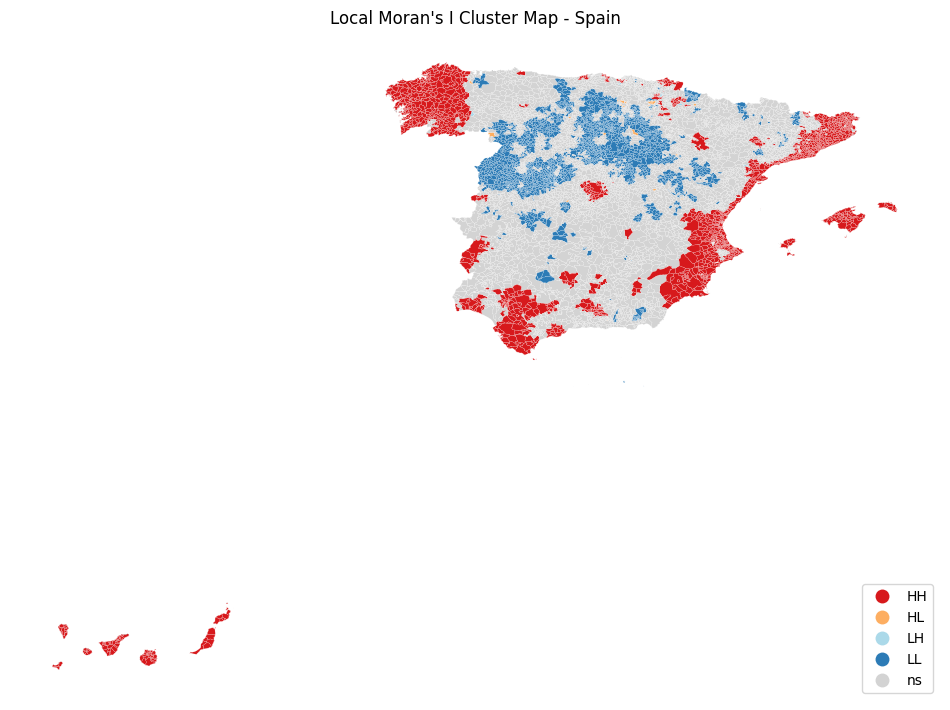

In [18]:
# Set up figure and axes
fig, ax = plt.subplots(1, figsize=(12, 12))

# Moran's I Cluster map (were Local Moran's I is significant)
# Plot Quandrant colors with 5% significance level
esdaplot.lisa_cluster(
    lisa, 
    geo_info, 
    p=0.05, 
    ax=ax,
    legend=True, 
    legend_kwds={'loc':'lower right'},
    figsize=(12, 12)
    )

### Set titles of subplots ###
ax.set_title("Local Moran's I Cluster Map - " + AREA_TO_PREDICT)
#f.tight_layout()

if SAVE_FIGS is True:
    plt.savefig(DIR_LSA + "local_statistics.svg", format="svg")

# Display the figure
plt.show()

In [0]:
lisa.q[:10]

In [0]:
# 1 = HH, 2 = LH, 3 = LL, 4 = HL (H = high, L = low)
counts = pd.value_counts(lisa.q)
counts

In [0]:
# Calculate the degree of municipalities that is part of a social cluster
(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)

In [0]:
# Calculate significance (p-value)
# Assign pseudo P-values to `geo_info`
geo_info["p-sim"] = lisa.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa.p_sim < 0.05)
# Assign significance flag to `geo_info`
geo_info["sig"] = sig
# Print top of the table 
geo_info[["sig", "p-sim"]].head()

In [0]:
# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = lisa.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `geo_info` with labels for each polygon
geo_info["labels"] = pd.Series(
    # First initialise a Series using values and `geo_info` index
    spots,
    index=geo_info.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
geo_info["labels"].head()

In [0]:
geo_info["labels"].value_counts()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f11c3f49-2b5e-4e69-9186-d202c2d21fb7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>